In [1]:
import pandas as pd

In [ ]:
data = pd.read_excel('DadosG1.xlsx')
data["Valor"] = data["Valor"].str.replace(",",".")
data = data.reset_index(drop=True)
data["Data Coleta"] = pd.to_datetime(data["Data Coleta"], format="%d/%m/%Y")

cols = [
    "Valor",
    "Data Coleta",
    "Parametro",
    "Unidade"
]

params = [
    'pH',
    'Temperatura da Água',
    'Escherichia coli**',
    'Temperatura do Ar',
    'Turbidez',
    'Nitrogênio Kjeldahl',
    'Nitrogênio-Nitrito',
    'Nitrogênio-Nitrato',
    'Oxigênio Dissolvido',
    'Sólido Total',
    'Fósforo Total',
]

data = data.loc[data['Parametro'].isin(params), cols]
data['Valor'] = data['Valor'].astype(float)

data_nitrogenio = data.loc[data['Parametro'].isin(['Nitrogênio Kjeldahl', 'Nitrogênio-Nitrito','Nitrogênio-Nitrato'])]
data_nitrogenio.loc[:, 'Valor'] = data_nitrogenio['Valor']

nitrogenio_list = data_nitrogenio.groupby(['Data Coleta'])['Valor'].sum()

nitrogenio = pd.DataFrame()
nitrogenio['Data Coleta'] = nitrogenio_list.index
nitrogenio['Valor'] = nitrogenio_list.values
nitrogenio['Parametro'] = 'Nitrogênio Total'
nitrogenio['Unidade'] = 'mg/L'

data.drop(data.loc[data['Parametro'].isin(['Nitrogênio Kjeldahl', 'Nitrogênio-Nitrito','Nitrogênio-Nitrato'])].index, inplace=True)
data = data.merge(nitrogenio, how='outer')

delta_temperatura = data.loc[data['Parametro'].isin(['Temperatura da Água', 'Temperatura do Ar']), ['Data Coleta', 'Parametro', 'Valor', 'Unidade']]

df_pivot = delta_temperatura.pivot(index="Data Coleta", columns="Parametro", values="Valor")

df_pivot.columns = ["Temperatura do Ar", "Temperatura da Água"]

df_pivot["Delta Temperatura"] = abs(df_pivot["Temperatura da Água"] - df_pivot["Temperatura do Ar"])
df_pivot['Unidade'] = '°C'
df_pivot['Parametro'] = 'Delta Temperatura'
df_pivot = df_pivot.rename(columns={'Delta Temperatura': 'Valor'})
df_pivot = df_pivot[['Parametro', 'Valor', 'Unidade']]
df_pivot.reset_index(inplace=True)

data = data.merge(df_pivot, how='outer')

data.loc[data['Parametro'] == 'Escherichia coli**', 'Valor'] = data.loc[data['Parametro'] == 'Escherichia coli**', 'Valor'] * 1.25
data.loc[data['Parametro'] == 'Escherichia coli**', 'Parametro'] = 'Coliformes Termotolerantes'

data.sort_values(['Parametro', 'Data Coleta'], inplace=True)

data = data[['Data Coleta', 'Parametro', 'Valor', 'Unidade']]

In [8]:
data['Parametro'].unique()

array(['Coliformes Termotolerantes', 'Delta Temperatura', 'Fósforo Total',
       'Nitrogênio Total', 'Oxigênio Dissolvido', 'Sólido Total',
       'Temperatura da Água', 'Temperatura do Ar', 'Turbidez', 'pH'],
      dtype=object)

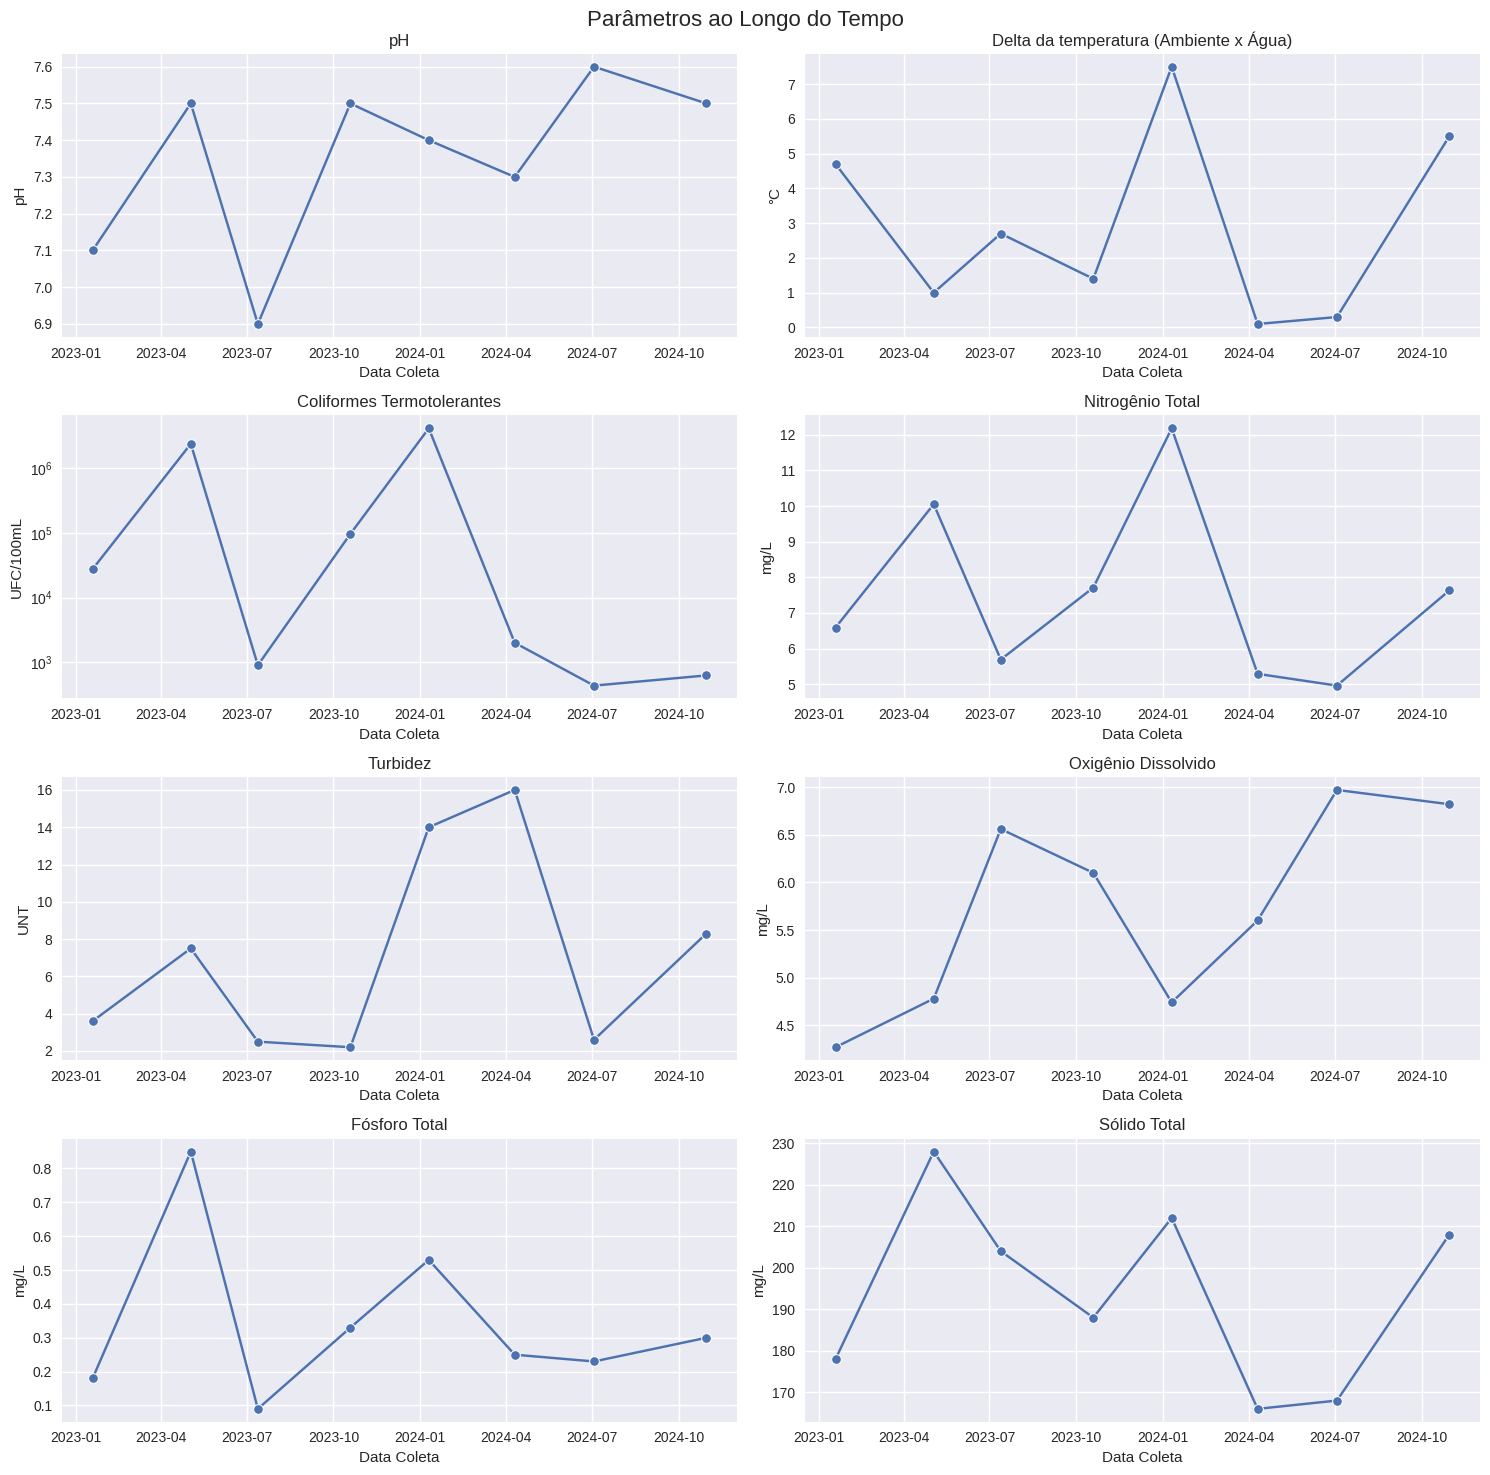

In [15]:
import seaborn as sns

import matplotlib.pyplot as plt

# Set the style and figure size
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
fig.suptitle('Parâmetros ao Longo do Tempo', size=16)

# Plot 1: pH
sns.lineplot(data=data[data['Parametro']=='pH'], 
            x='Data Coleta', y='Valor', 
            marker='o', ax=axes[0,0])
axes[0,0].set_title('pH')
axes[0,0].set_ylabel('pH')

# Plot 2: Temperatura
temp_data = data[data['Parametro'].isin(['Delta Temperatura'])]
sns.lineplot(data=temp_data, x='Data Coleta', y='Valor', marker='o', ax=axes[0,1])
axes[0,1].set_title('Delta da temperatura (Ambiente x Água)')
axes[0,1].set_ylabel('°C')

# Plot 3: Coliformes (log scale due to large range)
sns.lineplot(data=data[data['Parametro']=='Coliformes Termotolerantes'], 
            x='Data Coleta', y='Valor', 
            marker='o', ax=axes[1,0])
axes[1,0].set_yscale('log')
axes[1,0].set_title('Coliformes Termotolerantes')
axes[1,0].set_ylabel('UFC/100mL')

# Plot 4: Nitrogênio Total
sns.lineplot(data=data[data['Parametro']=='Nitrogênio Total'], 
            x='Data Coleta', y='Valor', 
            marker='o', ax=axes[1,1])
axes[1,1].set_title('Nitrogênio Total')
axes[1,1].set_ylabel('mg/L')

# Plot 5: Turbidez
sns.lineplot(data=data[data['Parametro']=='Turbidez'], 
            x='Data Coleta', y='Valor', 
            marker='o', ax=axes[2,0])
axes[2,0].set_title('Turbidez')
axes[2,0].set_ylabel('UNT')

# Plot 6: Oxigênio Dissolvido
sns.lineplot(data=data[data['Parametro']=='Oxigênio Dissolvido'], 
            x='Data Coleta', y='Valor', 
            marker='o', ax=axes[2,1])
axes[2,1].set_title('Oxigênio Dissolvido')
axes[2,1].set_ylabel('mg/L')

# Plot 7: Fósforo total
sns.lineplot(data=data[data['Parametro']=='Fósforo Total'], 
            x='Data Coleta', y='Valor', 
            marker='o', ax=axes[3,0])
axes[3,0].set_title('Fósforo Total')
axes[3,0].set_ylabel('mg/L')

# Plot 8: Fósforo total
sns.lineplot(data=data[data['Parametro']=='Sólido Total'], 
            x='Data Coleta', y='Valor', 
            marker='o', ax=axes[3,1])
axes[3,1].set_title('Sólido Total')
axes[3,1].set_ylabel('mg/L')


# Adjust layout and display
plt.tight_layout()
plt.show()